<h3>Scraping Twitter: University Marketplace</h3>

Introduction

Here we are using twitter API to extract tweets related to buy and sell of used items in twitter. After extracting all the tweets using the API related to our search value, we will save all the records in our MySQL tables (tweet, tweet_mentions, tweet_tags). 

<h3>Importing Essential Libraries</h3>

In [1]:
import tweepy
import configparser
import pandas as pd
import pymysql
import matplotlib
pymysql.install_as_MySQLdb()
import mysql.connector
from mysql.connector import Error

<h3>Authentication keys</h3>

Here we are defining keys to authenticate with twitter API and start calling API functions to extract tweets for our analysis.

You need to register for a Twitter dev account https://developer.twitter.com

Look at the Twitter data model https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet

Apply for a Twitter Developer Account

Go to the Twitter developer site to apply for a developer account.

Step 2: Create an Application

Twitter grants authentication credentials to apps, not accounts. An app can be any tool or bot that uses the Twitter API. So you need to register your an app to be able to make API calls.

To register your app, go to your Twitter apps page and select the Create an app option.

You need to provide the following information about your app and its purpose:

App name: a name to identify your application (such as examplebot) Application description: the purpose of your application (such as An example bot for a Real Python article) Your or your application’s website URL: required, but can be your personal site’s URL since bots don’t need a URL to work Use of the app: how users will use your app (such as This app is a bot that will automatically respond to users) Step 3: Create the Authentication Credentials

To create the authentication credentials, go to your Twitter apps page. Here’s what the Apps page looks like:

Edit app details Here you’ll find the Details button of your app. Clicking this button takes you to the next page, where you can generate the credentials.

By selecting the Keys and tokens tab, you can generate and copy the key, token, and secrets to use them in your code:

Generate keys and tokens After generating the credentials, save them to later use them in your code.

In [2]:
# read config from config.ini file
config = configparser.ConfigParser()
config.read('config.ini')

api_key = config['twitter']['api_key']
api_key_secret = config['twitter']['api_key_secret']
access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

<h3>Authentication</h3>

As we have previously seen, the Twitter API requires that all requests use OAuth to authenticate. So you need to create the required authentication credentials to be able to use the API. These credentials are four text strings:

Consumer key Consumer secret Access token Access secret

In [3]:
# Using Tweepy to authenticate user using api key and access token
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

# Checking if the api credentials is verified
try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


<h3>Extracting Tweets</h3>

We are using search_tweets function to get all the tweets with keyword 'selling a table'

In [20]:
# Searching tweets based on the text message
tweets = api.search_tweets('selling a table',count=10000)

# Checking the database connection 
try:
    connection = mysql.connector.connect(host='localhost',
                                         database='twitter_schema',
                                         user='root',
                                         password='root')
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version ", db_Info)
        cursor = connection.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("You're connected to database: ", record)
except Error as e:
    print("Error while connecting to MySQL", e)



Connected to MySQL Server version  8.0.31
You're connected to database:  ('twitter_schema',)


<h3>Loading the tweets into the MySQL database</h3>

In [8]:
# Looping over the entire tweets to fetch the required information and inserting the values in three twitter tables: tweet, tweet_mentions, tweet_tags

tweet_id_list = []
tweet_retweet_count_list = []
tweet_mentions_id_index = 1
tweet_tags_id_index = 1
for tweet in tweets:
    tweet_id = tweet.id
    created_at = tweet.created_at
    twitter_text = tweet.text
    username = tweet.user.screen_name
    name = tweet.user.name
    userId = tweet.user.id
    follower_count = tweet.user.followers_count
    following_count = tweet.user.friends_count
    twitter_handle = tweet.user.screen_name
    profile_image_url = tweet.user.profile_image_url_https
    description = tweet.user.description
    userCreated_at = tweet.user.created_at
    status = api.get_status(tweet_id)
    retweet_count = status.retweet_count 

    tweet_id_list.append(tweet_id)
    tweet_retweet_count_list.append(retweet_count)

    cursor.execute('''insert into tweet ( twitter_handle, tweet_text, profile_image_url, tweet_date, user_created_at, retweets) values ( %s, %s, %s, %s, %s, %s)''', ( twitter_handle, twitter_text, profile_image_url, created_at,userCreated_at,retweet_count))
    connection.commit()
    tweet_id_index = cursor._last_insert_id
    if(len(tweet.entities['user_mentions']) > 0):
        for mention in tweet.entities['user_mentions']:
            target_user = mention['screen_name']
            cursor.execute('''insert into tweet_mentions (tweet_id,source_user, target_user,tweet_mentions_id) values ( %s,%s, %s, %s)''', (tweet_id_index,twitter_handle, target_user,tweet_mentions_id_index))
            connection.commit()
            tweet_mentions_id_index = tweet_mentions_id_index + 1
    if(len(tweet.entities['hashtags']) > 0):
        for tag in tweet.entities['hashtags']:
            tag = tag['text']
            cursor.execute('''insert into tweet_tags (tweet_id,tag, target_user,tweet_tag_id) values (%s,%s, %s, %s)''', (tweet_id_index,tag,target_user,tweet_tags_id_index))
            connection.commit()
            tweet_tags_id_index = tweet_tags_id_index + 1

<h3>Audit Completeness and Audit Consistency</h3>

In [9]:
import pandas as pd

# Source for flipkart csv dataset from kaggle: https://www.kaggle.com/datasets/PromptCloudHQ/flipkart-products
# reading csv files
flipkart_csv_df = pd.read_csv('C:\\Personal_Documents\\Assignments\\DMDD\\data_sources\\flipkart_com-ecommerce_sample.csv',delimiter = ',')

# Source for orders csv from github: https://github.com/pawarbi/datasets/blob/master/Orders.csv
# reading csv files
order_df = pd.read_csv('C:\\Personal_Documents\\Assignments\\DMDD\\data_sources\\orders.csv',delimiter = ',')



#Code to clean the data by removing all the na values, drop all the unwanted columns and removing all the duplicates
flipkart_csv_df.drop(columns = [flipkart_csv_df.columns[0],flipkart_csv_df.columns[1],flipkart_csv_df.columns[2],flipkart_csv_df.columns[5],flipkart_csv_df.columns[6],flipkart_csv_df.columns[7],flipkart_csv_df.columns[8],flipkart_csv_df.columns[9],flipkart_csv_df.columns[10],flipkart_csv_df.columns[13],flipkart_csv_df.columns[14]],  inplace= True)
flipkart_csv_df.dropna()
flipkart_csv_df.drop_duplicates(subset=['product_name'])

#Code to clean the data by removing all the na values, drop all the unwanted columns and removing all the duplicates. We have also used rename function to rename the columns.
order_df.drop(columns = [order_df.columns[0],order_df.columns[1],order_df.columns[2],order_df.columns[4],order_df.columns[5],order_df.columns[6],order_df.columns[7],order_df.columns[8],order_df.columns[9],order_df.columns[10],order_df.columns[11],order_df.columns[12],order_df.columns[13],order_df.columns[14],order_df.columns[15],order_df.columns[17],order_df.columns[16],order_df.columns[19],order_df.columns[20],order_df.columns[21],order_df.columns[22],order_df.columns[23]],  inplace= True)
order_df.rename(columns={"Unit Price": "price", "Order Date": "order_date"}, inplace=True)
order_df.dropna()
order_df.drop_duplicates()

,price,order_date
0,2.88,5/28/2012
1,2.84,7/7/2010
2,6.68,7/27/2011
3,5.68,7/27/2011
4,205.99,7/27/2011
...,...,...
9421,35.89,5/14/2013
9422,3.34,5/14/2013
9423,550.98,9/12/2013
9424,105.98,2/8/2010


<h3>Code block to insert records in the Category table</h3>
We have written the code to insert the records in the category table.

In [10]:
category_id = 1
product_category_list = []
for index,data in flipkart_csv_df.iterrows(): 
    if index == 500:
        break 
    product_category_tree_df = data['product_category_tree']
    #To fetch only the root value of the product_category_tree using the below logic
    startString = '["'
    endString = ' >>'
    data['product_category_tree'] = product_category_tree_df[product_category_tree_df.find(startString)+len(startString):product_category_tree_df.find(endString)]
    product_category_list.append(data['product_category_tree'])
    cursor.execute('''insert into category (category_id,category_name) values (%s,%s)''', (category_id,data["product_category_tree"]))
    category_id = category_id + 1
    connection.commit()

<h3>Code block to insert records in the Product table</h3>
We have written the code to insert the records in the product table.

In [11]:
product_id = 1
category_id = 1
for index,data in flipkart_csv_df.iterrows():
    if index == 500:
        break 
    product_name_df = data['product_name']
    data['product_name'] = product_name_df[:100]
    cursor.execute('''insert into product (product_id,product_name,category_id) values (%s,%s,%s)''', (product_id, data["product_name"],category_id))
    connection.commit()
    product_id = product_id + 1
    category_id = category_id + 1

<h3>Code block to insert records in the Feedback table</h3>
We have written the code to insert the records in the feedback table.

In [12]:
feedback_id = 1
for index,data in flipkart_csv_df.iterrows():
    if index == 500:
        break
# We will use proucting rating to generate value for the comments column. If the rating is not available we will assign -1 score. 
    product_rating_df = data['product_rating']
    if product_rating_df == 'No rating available':
        comments = 'No comments for the product'
        feedback_score = -1
    else:
        feedback_score = round(float(product_rating_df.strip())) 
    

    rounded_feedback_score = feedback_score

# If the feedback score is less than 3, we will assign comment as 'Worst Product' else we will assing comment as 'Good Product'
    if rounded_feedback_score < 3:
        comments = 'Worst Product'
    else:
        comments = 'Good Product'
        
    cursor.execute('''insert into feedback (feedback_id,feedback_score,comments) values (%s,%s,%s)''', (feedback_id, feedback_score,comments))
    connection.commit()
    feedback_id = feedback_id + 1

<h4>Code to read us-colleges-and-universities csv and student.csv in dataframe. We have also cleaned and standardized the data by removing all the na and duplicate values.</h4>

In [13]:
import random

# Source for university dataset: https://public.opendatasoft.com/explore/dataset/us-colleges-and-universities/export/
# reading csv files
university = pd.read_csv('C:\\Personal_Documents\\Assignments\\DMDD\\data_sources\\us-colleges-and-universities.csv', sep=",")

# formatting university data
university = university[['OBJECTID', 'NAME', 'STATE', 'CITY']]
university = university.rename(columns={"OBJECTID": "university_id", "NAME": "university_name", "CITY": "city", "STATE": "state"})

#print(university.head(10))

# Source for student dataset: https://github.com/ShapeLab/ZooidsCompositePhysicalizations/blob/master/Zooid_Vis/bin/data/student-dataset.csv
# reading csv files
student = pd.read_csv('C:\\Personal_Documents\\Assignments\\DMDD\\data_sources\\student.csv', sep=",")

# formatting student data
student = student[['id', 'name']]
student[['first_name', 'last_name', 'temp']] = student.name.str.split(" ", expand=True)
student = student.drop('temp', axis=1)
student = student.rename(columns={"id": "student_id"})
student.dropna()

# generating random university ids for student
univ_id = []
for i in range(len(student)):
    univ_id.append(random.choice(university['university_id']))

# adding university_id to student
student['university_id'] = ''
student['university_id'] = univ_id

#Populating buyer
buyer_id = random.sample(range(3, 100), 50)
stud_id = []

for i in range(50):
    stud_id.append(random.choice(student['student_id']))

temp_data = {'buyer_id': buyer_id,
        'student_id': stud_id}

buyer = pd.DataFrame(temp_data)

#Populating seller
seller_id = random.sample(range(103, 200), 50)
premium_flag = []
stud_id = []

for i in range(50):
    premium_flag.append(random.randint(0,1))

for i in range(50):
    stud_id.append(random.choice(student['student_id']))

temp_data = {'seller_id': seller_id,
            'student_id': stud_id,
            'premium_flag':premium_flag}

seller = pd.DataFrame(temp_data)
seller.dropna()

,seller_id,student_id,premium_flag
0,162,225,0
1,182,80,1
2,186,95,0
3,138,178,1
4,168,154,0
5,187,290,0
6,126,290,1
7,141,189,0
8,103,121,0
9,148,151,0


<h3>Boxplot to view the consistency and range of data for the premium flag in the seller table</h3>

<h3>Code block to insert records in the University table</h3>
We have written the code to insert the records in the university table.

In [14]:
#Inserting data into the database
# university_id = 1
for uni in university.iterrows():
    university_id = uni[1][0]
    university_name = uni[1][1]
    state = uni[1][2]
    city = uni[1][3]

    cursor.execute(
        '''insert into university (university_id, university_name, state, city) values ( %s, %s, %s, %s);''',
        (university_id, university_name, state, city))
    # university_id = university_id + 1
    connection.commit()

<h3>Code block to insert records in the Student table</h3>
We have written the code to insert the records in the student table.

In [15]:
for stud in student.iterrows():
    student_id = stud[1][0]
    university_id = stud[1][4]
    first_name = stud[1][2]
    last_name = stud[1][3]
    cursor.execute(
        '''insert into student (student_id, university_id, first_name, last_name) values ( %s, %s, %s, %s);''',
        (student_id, university_id, first_name, last_name))
    connection.commit()

<h3>Code block to insert records in the Buyer table</h3>
We have written the code to insert the records in the buyer table.

In [16]:
for b in buyer.iterrows():
    student_id = int(b[1][1])
    buyer_id = int(b[1][0])
    cursor.execute(
        '''insert into buyer (buyer_id, student_id) values ( %s, %s);''',
        (buyer_id, student_id))
    connection.commit()

<h3>Code block to insert records in the Seller table</h3>
We have written the code to insert the records in the seller table.

In [17]:
for s in seller.iterrows():
    student_id = int(s[1][1])
    seller_id = int(s[1][0])
    premium_flag = int(s[1][2])

    cursor.execute(
        '''insert into seller (seller_id, student_id,premium_flag) values ( %s, %s, %s);''',
        (seller_id, student_id, premium_flag))
    connection.commit()

<h3>Code block to insert records in the Tweet Order table</h3>
We have written the code to insert the records in the tweet_order table.

In [21]:
t_order_id = 1
tweet_id = 1
product_id = 1
feedback_id = 1
t_order_details_id = 1

seller_id = []
buyer_id = []
price = []
seller_id_1 = []
product_id_1 = []
for i in range(len(order_df)):
    seller_id.append(random.choice(seller['seller_id']))

for i in range(len(order_df)):
    buyer_id.append(random.choice(buyer['buyer_id']))

temp_data = {
        'seller_id' : seller_id,
        'buyer_id' : buyer_id}

main_df = pd.DataFrame(temp_data)

result = pd.concat([main_df, order_df], axis=1)

for index,data in result.iterrows(): 
    if index == 500:
        break
    seller_id_1.append(data['seller_id'])
    product_id_1.append(product_id) 
    price.append(data['price'])
    d = data['order_date'].replace('/','-')
    data['order_date'] = d.split("-")[2]+"-"+d.split("-")[0]+"-"+d.split("-")[1]
    cursor.execute('''insert into twitter_order_header(t_order_id,buyer_id,seller_id,tweet_id,feedback_id,order_date) values (%s,%s,%s,%s,%s,%s)''', (t_order_id,data['buyer_id'],data['seller_id'],tweet_id,feedback_id,data['order_date']))
    connection.commit()
    cursor.execute('''insert into twitter_order_details(t_order_details_id, t_order_id,product_id, price) values (%s,%s,%s,%s)''', (t_order_details_id,t_order_id,product_id,data['price']))
    connection.commit()
    tweet_id = tweet_id + 1
    t_order_id = t_order_id + 1
    t_order_details_id = t_order_details_id + 1
    product_id = product_id + 1
    feedback_id = feedback_id + 1

<h3>This scatterplot represents a distribution of prices at which items were sold by Seller IDs. This indicates that the data is valid. </h3>

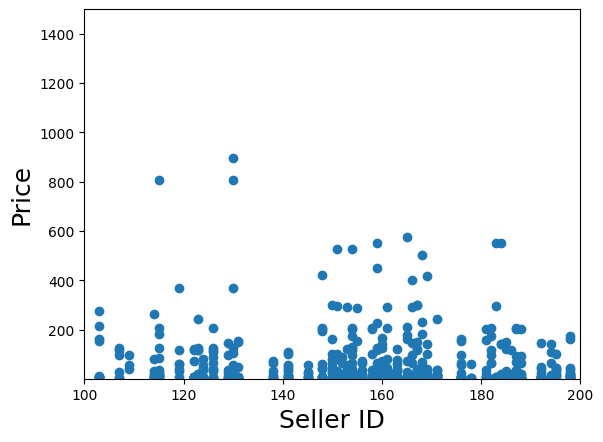

In [22]:
import matplotlib.pyplot as plt


plt.xlim([100, 200])
plt.ylim([1, 1500])
plt.xlabel('Seller ID', fontsize=18)
plt.ylabel('Price', fontsize=18)

plt.scatter(seller_id_1,price)

 

<h3> This scatterplot represents a distribution of prices at which products were sold in the system. This indicates that the data is valid. </h3>

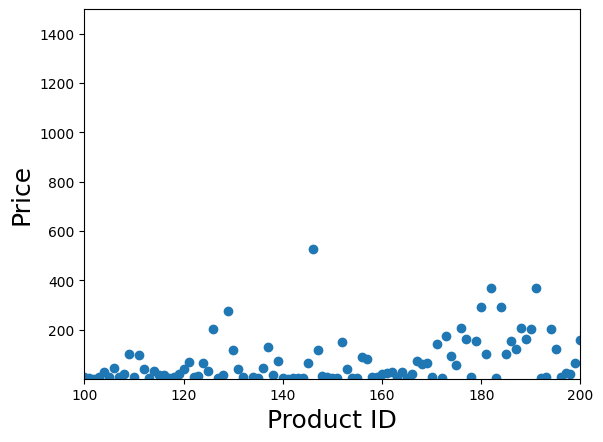

In [23]:
import matplotlib.pyplot as plt


plt.xlim([100, 200])
plt.ylim([1, 1500])
plt.xlabel('Product ID', fontsize=18)
plt.ylabel('Price', fontsize=18)


plt.scatter(product_id_1,price)



<h3>This box represents a univariate analysis of prica variable to identify whether the data is uniformly distributed or not. The boxplot indicates that the all the price data points are concentrated close to the lower limit. There are certain data points that are outliers but such outliers are present due to the presence of high value products. </h3>

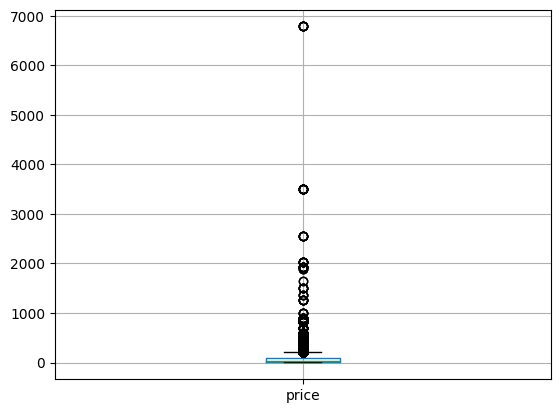

In [24]:
boxplot = order_df.boxplot(column=['price'])

# This box represents a univariate analysis of prica variable to identify whether the data is uniformly 
# distributed or not.
# The boxplot indicates that the all the price data points are concentrated close to the lower limit.
# There are certain data points that are outliers but such outliers are present due to the presence of high value products.

<h3> This bar graph represents category wise count of products in the system. Data accuracy can be validated using this graph by comparing the count with the source data. </h3>

<AxesSubplot: xlabel='Category', ylabel='count'>

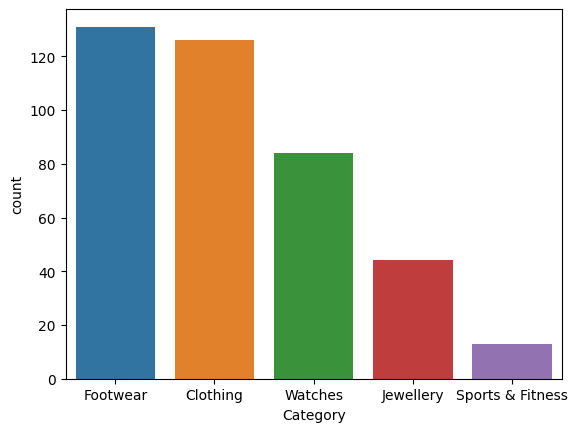

In [25]:
import seaborn as sns
df2 = pd.DataFrame(product_category_list)
df2.columns =['Category'] 
sns.countplot(x = 'Category',
              data = df2,
              order = df2['Category'].value_counts().head(5).index)


<h3>This boxplot shows the uniform and consistent distribution of premium flag variable. 
That is because all the data points lie between the inter quartile range. </h3>

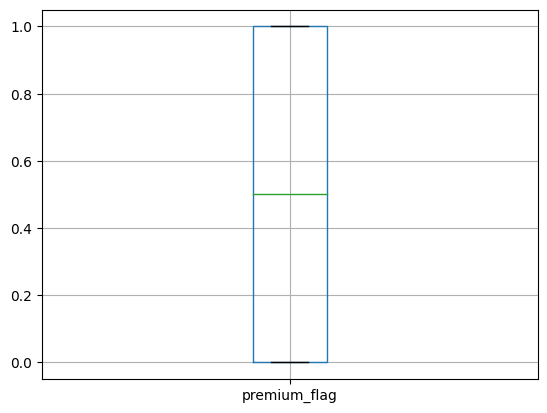

In [26]:
boxplot = seller.boxplot(column=['premium_flag'])
